In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
sys.path.append('../../')
sys.path.append('../data_processing/')
sys.path.append('../model/')
sys.path.append('../model/utils/')
sys.path.append('../model/EGNN_backbone')

In [73]:
from torch_geometric.loader import DataLoader
import torch
import torch.nn.functional as F
from omegaconf import OmegaConf
from rdkit import Chem

In [4]:
from data_processing.paired_data import PharmacophoreDataset, CombinedGraphDataset
from data_processing.reconstruction import get_atomic_number_from_index, is_aromatic_from_index, reconstruct_from_generated

In [28]:
from model.pp_bridge import PPBridge
from model.pp_bridge_sampler import PPBridgeSampler

In [6]:
config_file = '../../src/config/vp_bridge.yml'
# config_file = '../../src/config/ve_bridge.yml'
config = OmegaConf.load(config_file)
config

{'model': {'denoiser': {'bridge_type': 'vp', 'beta_d': 2, 'beta_min': 0.1, 'sigma_data': 0.5, 'sigma_max': 1, 'sigma_min': 0.0001, 'schedule_sampler': 'real-uniform', 'use_ema': True, 'ema_decay': 0.999, 'weight_decay': 1e-12, 'weight_schedule': 'bridge_karras', 'loss_x_weight': 100}, 'backbone': {'type': 'EGNN', 'feature_size': 13, 'num_layers': 6, 'hidden_size': 128, 'time_cond': True, 'xT_type': 'pp', 'xT_mode': 'concat_latent'}}, 'training': {'batch_size': 2500, 'log_interval': 100, 'save_interval': 1000, 'test_interval': 1000, 'total_training_steps': 10000000, 'learning_rate': 0.001, 'lr_anneal_steps': 0, 'max_epochs': 100, 'use_lr_scheduler': False, 'lr_scheduler_config': {'target': 'model.utils.lr_scheduler.LambdaLinearScheduler', 'params': {'warm_up_steps': [10000], 'cycle_lengths': [10000000000000], 'f_start': [1e-06], 'f_max': [1.0], 'f_min': [1.0]}}}, 'data': {'root': '../data/cleaned_crossdocked_data', 'max_node_num': 86, 'coord_dim': 3, 'module': 'CombinedGraphDataset'}}

In [7]:
ckpt_path = '../../src/lightning_logs/vp_bridge_2024-05-05_23_23_05.637117/epoch=10-val_loss=1815365.00.ckpt'
# ckpt_path = '../../src/lightning_logs/ve_bridge_2024-05-05_23_23_48.007100/epoch=07-val_loss=57275.88.ckpt'
# ckpt = torch.load(ckpt_path)
# ckpt

In [8]:
device = 'cuda:0'

In [29]:
sampler = PPBridgeSampler(config, ckpt_path, device)

Using real uniform sampler
Using real uniform sampler


In [30]:
for p in sampler.bridge_model.backbone.parameters():
    print(p.name, p.data.device)

None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None

In [31]:
root = '/data/conghao001/pharmacophore2drug/PP2Drug/data/cleaned_crossdocked_data'
split = 'test'
batch_size = 10
num_workers = 0

In [32]:
dataset = CombinedGraphDataset(root, split)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [80]:
len(dataset)

23291

In [33]:
one = next(iter(dataloader))
one = one.to(device)
one

DataBatch(x=[10, 172, 13], pos=[10, 172, 3], original_x=[238, 13], original_pos=[238, 3], target_x=[10, 172, 13], target_pos=[10, 172, 3], CoM=[10, 3], node_mask=[10, 172], Gt_mask=[1720], edge_mask=[10, 29584], node_pp_index=[1, 1720], ligand_name=[10], num_nodes=238, batch=[238], ptr=[11])

In [77]:
one.ligand_name

['3b65_A_rec_2axa_fhm_lig_tt_docked_0',
 '3b5r_A_rec_5t8e_77u_lig_tt_min_0',
 '2q7k_A_rec_2ihq_lg7_lig_tt_docked_0',
 '3b65_A_rec_4ojb_198_lig_tt_min_0',
 '3v4a_A_rec_4oha_hft_lig_tt_min_0',
 '4ql8_A_rec_1i38_dht_lig_tt_min_0',
 '3rll_A_rec_3b5r_b5r_lig_tt_docked_2',
 '1i38_A_rec_5cj6_51y_lig_tt_min_0',
 '5v8q_A_rec_5t8j_77t_lig_tt_min_0',
 '2ax9_A_rec_5v8q_97a_lig_tt_docked_1']

In [34]:
tmp_mask = one.Gt_mask.view(batch_size, -1)
# tmp_mask.size()
one.target_x[0][tmp_mask[0]].size()

torch.Size([30, 13])

In [35]:
for node_feat in one.target_x[0][tmp_mask[0]]:
    print(node_feat)

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dev

In [36]:
_, _, Gt_mask, batch_info = sampler.preprocess(one.target_pos, one.target_x, node_mask=one.node_mask, Gt_mask=one.Gt_mask, batch_info=one.batch, device=device)

In [37]:
Gt_mask.size(), batch_info.size(), Gt_mask.sum()

(torch.Size([476]), torch.Size([476]), tensor(238, device='cuda:0'))

## Important
***sigma min and max values***
differ for ve/vp bridges!!!

In [39]:
steps = 40
# x, x_traj, h, h_traj, nfe = sampler.sample(one.target_pos, one.target_x, steps, node_mask=one.node_mask, Gt_mask=one.Gt_mask, batch_info=one.batch, churn_step_ratio=0.33, device=device)
x, x_traj, h, h_traj, nfe = sampler.sample(one.target_pos, one.target_x, steps, node_mask=one.node_mask, Gt_mask=one.Gt_mask, batch_info=one.batch, sigma_min=0.001, sigma_max=1, churn_step_ratio=0.33, device=device)

current sigma: tensor(0.9999, device='cuda:0')
c_skip, c_out, c_in tensor([[0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002

mij tensor([[-0.1037, -0.1080, -0.1292,  ..., -0.1006, -0.1170,  0.1447],
        [-0.1038, -0.1081, -0.1292,  ..., -0.1006, -0.1170,  0.1454],
        [-0.1038, -0.1080, -0.1292,  ..., -0.1006, -0.1170,  0.1454],
        ...,
        [-0.1157, -0.1162, -0.1335,  ..., -0.0990, -0.1173,  0.3687],
        [-0.1158, -0.1164, -0.1335,  ..., -0.0990, -0.1173,  0.3722],
        [-0.1159, -0.1168, -0.1336,  ..., -0.0990, -0.1173,  0.3775]],
       device='cuda:0')
denoised_h: tensor([[2.0318e-03, 4.7670e-01, 5.0162e-04,  ..., 4.4278e-04, 6.0169e-04,
         1.6645e-03],
        [2.0832e-03, 4.7639e-01, 5.0676e-04,  ..., 4.5118e-04, 6.1293e-04,
         1.6704e-03],
        [2.0371e-03, 4.7662e-01, 5.0404e-04,  ..., 4.4474e-04, 6.0444e-04,
         1.6709e-03],
        ...,
        [3.8462e-02, 3.8462e-02, 3.8462e-02,  ..., 3.8462e-02, 3.8462e-02,
         3.8462e-02],
        [3.8643e-02, 3.8462e-02, 3.8462e-02,  ..., 3.8462e-02, 3.8462e-02,
         3.8462e-02],
        [3.8643e-02, 3.8462e

c_skip, c_out, c_in tensor([[0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        

input h: tensor([[ 1.1690e+00,  1.6176e+00,  1.5823e+00,  ...,  1.2793e-04,
         -9.1622e-01,  2.6306e-02],
        [ 1.4377e+00, -4.7498e-01, -5.4458e-01,  ..., -2.9428e-02,
         -2.5978e-02,  1.9651e-02],
        [ 9.9605e-01,  2.9803e-01, -9.2999e-01,  ...,  5.8754e-01,
          1.5227e+00,  1.3165e-02],
        ...,
        [-4.4597e-01, -3.1872e-01, -2.0850e-01,  ...,  7.7786e-01,
         -3.9096e-01, -7.2804e-02],
        [ 1.3055e+00,  1.0331e-01, -4.8924e-01,  ..., -9.3650e-01,
         -9.5267e-01, -6.6071e-01],
        [-3.7750e-01, -7.1590e-01, -1.2200e+00,  ...,  2.9370e-02,
          1.0520e+00, -1.5520e+00]], device='cuda:0')
edge index tensor([[ 15,  16,  11,  ..., 434, 439, 453],
        [  0,   0,   0,  ..., 475, 475, 475]], device='cuda:0')
input to edge mlp
hi tensor([[ 3.9589,  3.4830,  5.1633,  ...,  3.3404, -2.5437,  7.6246],
        [ 3.9589,  3.4830,  5.1633,  ...,  3.3404, -2.5437,  7.6246],
        [ 3.9589,  3.4830,  5.1633,  ...,  3.3404, -2.5437, 

mij tensor([[-0.1382, -0.0231,  0.1739,  ...,  0.1778, -0.1257,  0.1603],
        [-0.1389, -0.0231,  0.1739,  ...,  0.1777, -0.1261,  0.1604],
        [-0.1395, -0.0231,  0.1740,  ...,  0.1777, -0.1265,  0.1606],
        ...,
        [-0.1489, -0.0140,  0.1822,  ...,  0.1702, -0.1202,  0.1487],
        [-0.1447, -0.0141,  0.1819,  ...,  0.1705, -0.1173,  0.1474],
        [-0.1452, -0.0140,  0.1820,  ...,  0.1704, -0.1175,  0.1475]],
       device='cuda:0')
edge index tensor([[ 19,  22,  13,  ..., 453, 446, 439],
        [  0,   0,   0,  ..., 475, 475, 475]], device='cuda:0')
input to edge mlp
hi tensor([[ 1.1494, -0.6488,  1.2793,  ...,  0.8952, -0.7196, -0.5680],
        [ 1.1494, -0.6488,  1.2793,  ...,  0.8952, -0.7196, -0.5680],
        [ 1.1494, -0.6488,  1.2793,  ...,  0.8952, -0.7196, -0.5680],
        ...,
        [ 0.0000, -0.0000,  0.0000,  ...,  0.0000, -0.0000, -0.0000],
        [ 0.0000, -0.0000,  0.0000,  ...,  0.0000, -0.0000, -0.0000],
        [ 0.0000, -0.0000,  0.000

        [0.2263]], device='cuda:0') tensor([[0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0.4805],
        [0

hj tensor([[ 0.1788,  0.2686,  0.1209,  ...,  0.6570,  0.2497, -0.2433],
        [ 0.1963,  0.2850,  0.1006,  ...,  0.6739,  0.2649, -0.2286],
        [ 0.1570,  0.2499,  0.1428,  ...,  0.6397,  0.2311, -0.2610],
        ...,
        [ 0.4776,  0.5273, -0.1891,  ...,  0.8882,  0.4712, -0.0016],
        [ 0.4503,  0.5030, -0.1612,  ...,  0.8659,  0.4488, -0.0238],
        [ 0.4293,  0.4843, -0.1396,  ...,  0.8483,  0.4320, -0.0403]],
       device='cuda:0')
edge_feat tensor([[5.0093e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.1099e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.1141e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        ...,
        [3.2219e+03, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.2223e+03, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.2270e+03, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00]],
       device='cuda:0')
mij tensor([[ 0.0719,  0.1004, -0.1039,  ...,  0.1215,  0.1064,  0.1040

mij tensor([[-0.1390, -0.0231,  0.1739,  ...,  0.1776, -0.1266,  0.1607],
        [-0.1404, -0.0230,  0.1741,  ...,  0.1775, -0.1275,  0.1611],
        [-0.1378, -0.0231,  0.1738,  ...,  0.1777, -0.1258,  0.1604],
        ...,
        [-0.1247, -0.0186,  0.1775,  ...,  0.1748, -0.1080,  0.1470],
        [-0.1266, -0.0184,  0.1777,  ...,  0.1746, -0.1091,  0.1473],
        [-0.1251, -0.0184,  0.1776,  ...,  0.1747, -0.1081,  0.1469]],
       device='cuda:0')
edge index tensor([[ 16,  13,   5,  ..., 438, 443, 435],
        [  0,   0,   0,  ..., 475, 475, 475]], device='cuda:0')
input to edge mlp
hi tensor([[ 1.2115, -0.7367,  1.3673,  ...,  0.9688, -0.7898, -0.6413],
        [ 1.2115, -0.7367,  1.3673,  ...,  0.9688, -0.7898, -0.6413],
        [ 1.2115, -0.7367,  1.3673,  ...,  0.9688, -0.7898, -0.6413],
        ...,
        [ 0.0000, -0.0000,  0.0000,  ...,  0.0000, -0.0000, -0.0000],
        [ 0.0000, -0.0000,  0.0000,  ...,  0.0000, -0.0000, -0.0000],
        [ 0.0000, -0.0000,  0.000

c_skip, c_out, c_in tensor([[0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        [0.3240],
        

        [0.4638]], device='cuda:0') tensor([[1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1.6136],
        [1

mij tensor([[ 0.1319, -0.0481, -0.0600,  ...,  0.1761,  0.1539,  0.1784],
        [ 0.1318, -0.0480, -0.0597,  ...,  0.1760,  0.1539,  0.1780],
        [ 0.1314, -0.0476, -0.0583,  ...,  0.1758,  0.1536,  0.1765],
        ...,
        [ 0.1353, -0.0638, -0.0832,  ...,  0.1861,  0.1529,  0.2230],
        [ 0.1348, -0.0634, -0.0815,  ...,  0.1858,  0.1526,  0.2212],
        [ 0.1352, -0.0638, -0.0828,  ...,  0.1861,  0.1529,  0.2227]],
       device='cuda:0')
edge index tensor([[ 13,  15,  22,  ..., 443, 449, 435],
        [  0,   0,   0,  ..., 475, 475, 475]], device='cuda:0')
input to edge mlp
hi tensor([[ 0.4194,  0.4960, -0.1521,  ...,  0.8638,  0.4291, -0.0444],
        [ 0.4194,  0.4960, -0.1521,  ...,  0.8638,  0.4291, -0.0444],
        [ 0.4194,  0.4960, -0.1521,  ...,  0.8638,  0.4291, -0.0444],
        ...,
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.000

hi tensor([[14.7562,  9.6084, 20.6563,  ..., 13.2908, -9.3952, 29.9253],
        [14.7562,  9.6084, 20.6563,  ..., 13.2908, -9.3952, 29.9253],
        [14.7562,  9.6084, 20.6563,  ..., 13.2908, -9.3952, 29.9253],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.0000]],
       device='cuda:0')
hj tensor([[14.2304,  8.7349, 20.0334,  ..., 12.9652, -9.4910, 29.7886],
        [14.7192,  9.2652, 20.1871,  ..., 13.2428, -9.3288, 29.5250],
        [13.7957,  8.6021, 19.0371,  ..., 13.0408, -8.8920, 29.0119],
        ...,
        [14.7266,  9.3289, 20.1921,  ..., 13.0539, -8.3109, 29.8382],
        [13.9122,  8.2983, 19.5162,  ..., 13.3582, -7.9351, 29.2286],
        [14.8491,  8.5421, 20.3315,  ..., 13.5259, -8.7857, 29.9486]],
       device='cuda:0')
edge_feat tensor([[2.4094e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]

hj tensor([[-0.3212, -0.0617,  0.1066,  ...,  0.2425, -0.0897, -0.0769],
        [-0.3472, -0.0618,  0.0997,  ...,  0.2657, -0.0816, -0.0621],
        [-0.3507, -0.0733,  0.0829,  ...,  0.2672, -0.0628, -0.0720],
        ...,
        [-0.1834,  0.1079,  0.2068,  ...,  0.1096, -0.1669, -0.1954],
        [-0.1745,  0.1142,  0.2231,  ...,  0.1079, -0.1841, -0.1934],
        [-0.1755,  0.1167,  0.2159,  ...,  0.1079, -0.1794, -0.1944]],
       device='cuda:0')
edge_feat tensor([[1.6246e-03, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.6384e-02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.9843e-02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        ...,
        [2.2887e+03, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.2948e+03, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.3131e+03, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00]],
       device='cuda:0')
mij tensor([[ 0.1312, -0.0474, -0.0576,  ...,  0.1756,  0.1535,  0.1758

edge index tensor([[ 16,  13,  22,  ..., 437, 446, 435],
        [  0,   0,   0,  ..., 475, 475, 475]], device='cuda:0')
input to edge mlp
hi tensor([[-0.2717, -0.1582,  0.0520,  ...,  0.2431,  0.0210, -0.2196],
        [-0.2717, -0.1582,  0.0520,  ...,  0.2431,  0.0210, -0.2196],
        [-0.2717, -0.1582,  0.0520,  ...,  0.2431,  0.0210, -0.2196],
        ...,
        [-0.0000,  0.0000, -0.0000,  ...,  0.0000, -0.0000,  0.0000],
        [-0.0000,  0.0000, -0.0000,  ...,  0.0000, -0.0000,  0.0000],
        [-0.0000,  0.0000, -0.0000,  ...,  0.0000, -0.0000,  0.0000]],
       device='cuda:0')
hj tensor([[-0.2578, -0.1368,  0.0789,  ...,  0.2307, -0.0045, -0.2075],
        [-0.2621, -0.1491,  0.0617,  ...,  0.2320,  0.0154, -0.2177],
        [-0.2325, -0.1374,  0.0854,  ...,  0.2075, -0.0120, -0.2217],
        ...,
        [-0.0660,  0.0758,  0.2151,  ...,  0.0433, -0.1144, -0.3558],
        [-0.0569,  0.0824,  0.2313,  ...,  0.0417, -0.1319, -0.3535],
        [-0.0587,  0.0849,  0.2237

mij tensor([[ 0.1314, -0.0476, -0.0580,  ...,  0.1758,  0.1536,  0.1760],
        [ 0.1306, -0.0468, -0.0551,  ...,  0.1752,  0.1531,  0.1730],
        [ 0.1310, -0.0473, -0.0569,  ...,  0.1755,  0.1534,  0.1748],
        ...,
        [ 0.1338, -0.0604, -0.0762,  ...,  0.1839,  0.1524,  0.2121],
        [ 0.1338, -0.0606, -0.0765,  ...,  0.1840,  0.1524,  0.2126],
        [ 0.1342, -0.0609, -0.0777,  ...,  0.1843,  0.1526,  0.2140]],
       device='cuda:0')
edge index tensor([[ 13,  16,  25,  ..., 438, 453, 435],
        [  0,   0,   0,  ..., 475, 475, 475]], device='cuda:0')
input to edge mlp
hi tensor([[ 0.6234,  0.6873, -0.3829,  ...,  1.0414,  0.5890,  0.1223],
        [ 0.6234,  0.6873, -0.3829,  ...,  1.0414,  0.5890,  0.1223],
        [ 0.6234,  0.6873, -0.3829,  ...,  1.0414,  0.5890,  0.1223],
        ...,
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.000

edge index tensor([[ 13,  16,   2,  ..., 441, 437, 449],
        [  0,   0,   0,  ..., 475, 475, 475]], device='cuda:0')
input to edge mlp
hi tensor([[ 0.8543, -1.1112, -1.0373,  ...,  0.7046,  1.0840, -1.4020],
        [ 0.8543, -1.1112, -1.0373,  ...,  0.7046,  1.0840, -1.4020],
        [ 0.8543, -1.1112, -1.0373,  ...,  0.7046,  1.0840, -1.4020],
        ...,
        [-0.0000, -0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000]],
       device='cuda:0')
hj tensor([[ 0.8833, -1.1373, -1.0765,  ...,  0.7306,  1.1176, -1.4368],
        [ 0.9064, -1.1578, -1.1078,  ...,  0.7517,  1.1441, -1.4644],
        [ 0.9833, -1.2262, -1.2116,  ...,  0.8208,  1.2331, -1.5558],
        ...,
        [ 1.4836, -1.6720, -1.8863,  ...,  1.2721,  1.8111, -2.1505],
        [ 1.5973, -1.7733, -2.0395,  ...,  1.3747,  1.9418, -2.2861],
        [ 1.5275, -1.7111, -1.9455

hi tensor([[ 2.0259, -1.8321,  2.4922,  ...,  1.9339, -1.6723, -1.5661],
        [ 2.0259, -1.8321,  2.4922,  ...,  1.9339, -1.6723, -1.5661],
        [ 2.0259, -1.8321,  2.4922,  ...,  1.9339, -1.6723, -1.5661],
        ...,
        [ 0.0000, -0.0000,  0.0000,  ...,  0.0000, -0.0000, -0.0000],
        [ 0.0000, -0.0000,  0.0000,  ...,  0.0000, -0.0000, -0.0000],
        [ 0.0000, -0.0000,  0.0000,  ...,  0.0000, -0.0000, -0.0000]],
       device='cuda:0')
hj tensor([[ 2.0596, -1.8757,  2.5379,  ...,  1.9733, -1.7079, -1.6034],
        [ 2.1448, -1.9847,  2.6525,  ...,  2.0722, -1.7970, -1.6966],
        [ 2.0812, -1.9039,  2.5671,  ...,  1.9983, -1.7307, -1.6274],
        ...,
        [ 2.6131, -2.5660,  3.2743,  ...,  2.6213, -2.2763, -2.1962],
        [ 2.7392, -2.7200,  3.4396,  ...,  2.7674, -2.4038, -2.3290],
        [ 2.6652, -2.6301,  3.3429,  ...,  2.6818, -2.3293, -2.2515]],
       device='cuda:0')
edge_feat tensor([[  6.4005,   1.0000,   0.0000,   0.0000,   0.0000],
        

c_skip, c_out, c_in tensor([[0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5065],
        

        [0.5702]], device='cuda:0') tensor([[0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0.3735],
        [0

        [0.3652]], device='cuda:0') tensor([[1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1.7272],
        [1

edge index tensor([[ 16,  13,   3,  ..., 443, 433, 451],
        [  0,   0,   0,  ..., 475, 475, 475]], device='cuda:0')
input to edge mlp
hi tensor([[ 0.8882,  0.9362, -0.6843,  ...,  1.2765,  0.8027,  0.3381],
        [ 0.8882,  0.9362, -0.6843,  ...,  1.2765,  0.8027,  0.3381],
        [ 0.8882,  0.9362, -0.6843,  ...,  1.2765,  0.8027,  0.3381],
        ...,
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')
hj tensor([[ 0.9127,  0.9574, -0.7089,  ...,  1.2961,  0.8237,  0.3563],
        [ 0.8965,  0.9436, -0.6917,  ...,  1.2823,  0.8067,  0.3450],
        [ 0.9362,  0.9805, -0.7345,  ...,  1.3174,  0.8400,  0.3768],
        ...,
        [ 1.1495,  1.1749, -0.9706,  ...,  1.4942,  1.0181,  0.5573],
        [ 1.1650,  1.1898, -0.9878,  ...,  1.5084,  1.0309,  0.5703],
        [ 1.2022,  1.2224, -1.0233

edge index tensor([[ 16,   3,   2,  ..., 438, 436, 433],
        [  0,   0,   0,  ..., 475, 475, 475]], device='cuda:0')
input to edge mlp
hi tensor([[ 2.1294,  2.4324,  2.7136,  ...,  1.2241, -2.4096, -2.0674],
        [ 2.1294,  2.4324,  2.7136,  ...,  1.2241, -2.4096, -2.0674],
        [ 2.1294,  2.4324,  2.7136,  ...,  1.2241, -2.4096, -2.0674],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000, -0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000, -0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000, -0.0000]],
       device='cuda:0')
hj tensor([[ 2.2127,  2.5067,  2.7940,  ...,  1.2638, -2.4945, -2.1507],
        [ 2.3020,  2.5870,  2.8808,  ...,  1.3066, -2.5865, -2.2404],
        [ 2.2776,  2.5650,  2.8570,  ...,  1.2950, -2.5613, -2.2158],
        ...,
        [ 3.2243,  3.3823,  3.7470,  ...,  1.7261, -3.5029, -3.1890],
        [ 2.9485,  3.1450,  3.4850,  ...,  1.5899, -3.2261, -2.9066],
        [ 3.1946,  3.3571,  3.7190

edge index tensor([[  2,  13,   3,  ..., 441, 433, 435],
        [  0,   0,   0,  ..., 475, 475, 475]], device='cuda:0')
input to edge mlp
hi tensor([[ 2.2446,  2.5597,  2.8485,  ...,  1.2656, -2.5575, -2.1841],
        [ 2.2446,  2.5597,  2.8485,  ...,  1.2656, -2.5575, -2.1841],
        [ 2.2446,  2.5597,  2.8485,  ...,  1.2656, -2.5575, -2.1841],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000, -0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000, -0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000, -0.0000]],
       device='cuda:0')
hj tensor([[ 2.3781,  2.6799,  2.9789,  ...,  1.3295, -2.6951, -2.3184],
        [ 2.2747,  2.5871,  2.8783,  ...,  1.2799, -2.5890, -2.2143],
        [ 2.3946,  2.6950,  2.9952,  ...,  1.3373, -2.7124, -2.3351],
        ...,
        [ 3.1016,  3.2999,  3.6530,  ...,  1.6523, -3.4057, -3.0658],
        [ 3.3040,  3.4747,  3.8464,  ...,  1.7524, -3.6098, -3.2738],
        [ 3.2062,  3.3904,  3.7531

current h: tensor([[ 0.7354,  0.3469,  0.4113,  ..., -0.0076, -0.2218, -0.0594],
        [-0.0157, -0.0659,  0.0657,  ..., -0.9018,  0.3945,  0.5021],
        [-0.0041,  0.4249, -0.7312,  ..., -0.4540,  0.2630, -0.1858],
        ...,
        [-0.2548, -0.4585, -0.4598,  ..., -0.0956, -0.2520, -0.2374],
        [-0.2958,  0.0698, -0.2399,  ..., -0.8701, -0.4936, -0.0857],
        [-0.4977, -0.2380,  0.0045,  ...,  0.3631,  0.2165, -0.5387]],
       device='cuda:0')
current x: tensor([[-50.5836,  -4.2648, -10.2194],
        [-51.5011,  -5.3537, -10.0875],
        [-50.5705,  -3.9809, -10.0946],
        ...,
        [ -0.4270,   0.3888,   1.0505],
        [  0.1172,  -1.3119,  -0.0775],
        [ -0.6633,  -0.2993,  -0.2222]], device='cuda:0')
current sigma: tensor(0.3347, device='cuda:0')
c_skip, c_out, c_in tensor([[0.6858],
        [0.6858],
        [0.6858],
        [0.6858],
        [0.6858],
        [0.6858],
        [0.6858],
        [0.6858],
        [0.6858],
        [0.6858],
  

c_skip, c_out, c_in tensor([[0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        [0.7024],
        

edge index tensor([[ 13,   2,  11,  ..., 449, 432, 437],
        [  0,   0,   0,  ..., 475, 475, 475]], device='cuda:0')
input to edge mlp
hi tensor([[-0.0111, -0.4904, -0.1036,  ...,  0.1496,  0.3938, -0.7648],
        [-0.0111, -0.4904, -0.1036,  ...,  0.1496,  0.3938, -0.7648],
        [-0.0111, -0.4904, -0.1036,  ...,  0.1496,  0.3938, -0.7648],
        ...,
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000, -0.0000,  0.0000],
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000, -0.0000,  0.0000],
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000, -0.0000,  0.0000]],
       device='cuda:0')
hj tensor([[-0.0089, -0.4813, -0.1055,  ...,  0.1388,  0.4019, -0.7642],
        [ 0.0091, -0.4819, -0.0909,  ...,  0.1341,  0.3850, -0.7721],
        [-0.0016, -0.4724, -0.0983,  ...,  0.1345,  0.3838, -0.7534],
        ...,
        [ 0.1760, -0.1895,  0.0863,  ..., -0.0518,  0.2173, -0.8419],
        [ 0.1835, -0.1878,  0.0879,  ..., -0.0590,  0.2067, -0.8352],
        [ 0.1989, -0.1792,  0.1012

denoised_h: tensor([[ 0.6143,  0.4436,  0.3178,  ...,  0.0470, -0.1395, -0.1305],
        [ 0.0067,  0.1936,  0.0017,  ..., -0.7110,  0.2467,  0.4376],
        [-0.0090,  0.3551, -0.4838,  ..., -0.4282,  0.2924, -0.1173],
        ...,
        [-0.1860, -0.3680, -0.3199,  ...,  0.0352, -0.1495, -0.1397],
        [-0.2285,  0.0278, -0.2544,  ..., -0.5478, -0.3704,  0.0453],
        [-0.3193, -0.0227,  0.0454,  ...,  0.2146,  0.1140, -0.3225]],
       device='cuda:0')
denoised_x: tensor([[-6.2393e+01, -5.7761e+00, -1.3004e+01],
        [-6.3125e+01, -6.3886e+00, -1.2577e+01],
        [-6.2503e+01, -5.6179e+00, -1.2805e+01],
        ...,
        [-3.7075e-01,  4.9677e-01,  1.5339e+00],
        [-1.2214e-01, -1.6749e+00,  6.7259e-02],
        [-5.5802e-01, -4.6335e-01, -5.7606e-02]], device='cuda:0')
current h: tensor([[ 0.8243,  0.4033,  0.6097,  ...,  0.1137, -0.1575, -0.1311],
        [-0.0834,  0.0967, -0.0084,  ..., -0.8954,  0.4015,  0.5132],
        [-0.0562,  0.2363, -0.6705,  ..., 

        [0.7360]], device='cuda:0') tensor([[0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0.2947],
        [0

input h: tensor([[ 1.4957,  0.7661,  1.1161,  ...,  0.2086, -0.2875, -0.2389],
        [-0.1652,  0.2060, -0.0149,  ..., -1.6381,  0.7353,  0.9401],
        [-0.1155,  0.4612, -1.2264,  ..., -0.9705,  0.8400, -0.1345],
        ...,
        [-0.6211, -0.8025, -0.8078,  ...,  0.3398, -0.2818, -0.4058],
        [-0.3988, -0.0292, -0.5674,  ..., -1.5874, -0.8646,  0.1796],
        [-1.2735,  0.0567,  0.1216,  ...,  0.6082,  0.0760, -0.8614]],
       device='cuda:0')
edge index tensor([[ 13,  11,  15,  ..., 446, 432, 437],
        [  0,   0,   0,  ..., 475, 475, 475]], device='cuda:0')
input to edge mlp
hi tensor([[ 38.5091,  23.3689,  53.2495,  ...,  35.3149, -23.6910,  79.2004],
        [ 38.5091,  23.3689,  53.2495,  ...,  35.3149, -23.6910,  79.2004],
        [ 38.5091,  23.3689,  53.2495,  ...,  35.3149, -23.6910,  79.2004],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,  -0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,  -0.0000,   0.0000]

edge index tensor([[ 13,  15,  16,  ..., 453, 433, 443],
        [  0,   0,   0,  ..., 475, 475, 475]], device='cuda:0')
input to edge mlp
hi tensor([[ 3.7337, -3.6770, -4.9036,  ...,  3.2911,  4.3587, -4.8337],
        [ 3.7337, -3.6770, -4.9036,  ...,  3.2911,  4.3587, -4.8337],
        [ 3.7337, -3.6770, -4.9036,  ...,  3.2911,  4.3587, -4.8337],
        ...,
        [-0.0000, -0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000]],
       device='cuda:0')
hj tensor([[ 3.7794, -3.7177, -4.9645,  ...,  3.3321,  4.4102, -4.8880],
        [ 3.9231, -3.8458, -5.1561,  ...,  3.4614,  4.5737, -5.0584],
        [ 3.8893, -3.8159, -5.1117,  ...,  3.4316,  4.5357, -5.0188],
        ...,
        [ 4.4778, -4.3351, -5.8960,  ...,  3.9634,  5.2105, -5.7119],
        [ 4.4648, -4.3233, -5.8786,  ...,  3.9516,  5.1956, -5.6963],
        [ 4.4434, -4.3044, -5.8500

edge_feat tensor([[  4.9084,   1.0000,   0.0000,   0.0000,   0.0000],
        [  7.9459,   1.0000,   0.0000,   0.0000,   0.0000],
        [  9.2001,   1.0000,   0.0000,   0.0000,   0.0000],
        ...,
        [127.5375,   0.0000,   1.0000,   0.0000,   0.0000],
        [142.2503,   0.0000,   1.0000,   0.0000,   0.0000],
        [154.9781,   0.0000,   1.0000,   0.0000,   0.0000]], device='cuda:0')
mij tensor([[-0.1039, -0.1099, -0.1319,  ..., -0.1010, -0.1185,  0.1814],
        [-0.1038, -0.1092, -0.1318,  ..., -0.1010, -0.1184,  0.1760],
        [-0.1038, -0.1069, -0.1317,  ..., -0.1009, -0.1181,  0.1598],
        ...,
        [-0.1016, -0.0228, -0.1240,  ..., -0.0963, -0.1048, -0.2110],
        [-0.1016, -0.0226, -0.1240,  ..., -0.0963, -0.1048, -0.2111],
        [-0.1017, -0.0236, -0.1241,  ..., -0.0964, -0.1049, -0.2091]],
       device='cuda:0')
current h: tensor([[ 0.6080,  0.5963,  0.6469,  ..., -0.0563, -0.2344,  0.0176],
        [ 0.1018,  0.0502, -0.0958,  ..., -0.9481,  0.36

c_skip, c_out, c_in tensor([[0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        [0.8302],
        

        [0.2446]], device='cuda:0') tensor([[1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1.8782],
        [1

mij tensor([[ 0.1285, -0.0447, -0.0473,  ...,  0.1736,  0.1520,  0.1640],
        [ 0.1286, -0.0448, -0.0476,  ...,  0.1737,  0.1521,  0.1642],
        [ 0.1286, -0.0448, -0.0475,  ...,  0.1736,  0.1521,  0.1641],
        ...,
        [ 0.1348, -0.0572, -0.0755,  ...,  0.1822,  0.1541,  0.2049],
        [ 0.1345, -0.0572, -0.0749,  ...,  0.1822,  0.1539,  0.2046],
        [ 0.1344, -0.0575, -0.0747,  ...,  0.1823,  0.1537,  0.2049]],
       device='cuda:0')
edge index tensor([[ 15,   2,  11,  ..., 432, 449, 437],
        [  0,   0,   0,  ..., 475, 475, 475]], device='cuda:0')
input to edge mlp
hi tensor([[ 1.6248,  1.6367, -1.5407,  ...,  1.9642,  1.4301,  0.9397],
        [ 1.6248,  1.6367, -1.5407,  ...,  1.9642,  1.4301,  0.9397],
        [ 1.6248,  1.6367, -1.5407,  ...,  1.9642,  1.4301,  0.9397],
        ...,
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.000

hj tensor([[ 1.6885,  1.6972, -1.6123,  ...,  2.0220,  1.4845,  0.9903],
        [ 1.7129,  1.7199, -1.6377,  ...,  2.0421,  1.4988,  1.0112],
        [ 1.6836,  1.6921, -1.6057,  ...,  2.0154,  1.4769,  0.9860],
        ...,
        [ 1.6759,  1.6909, -1.6068,  ...,  2.0110,  1.4875,  0.9972],
        [ 1.6993,  1.7137, -1.6331,  ...,  2.0326,  1.5074,  1.0160],
        [ 1.7225,  1.7349, -1.6585,  ...,  2.0522,  1.5286,  1.0323]],
       device='cuda:0')
edge_feat tensor([[5.9250e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [6.2313e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [7.2010e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        ...,
        [1.0242e+03, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0404e+03, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0805e+03, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00]],
       device='cuda:0')
mij tensor([[ 0.0699,  0.1026, -0.1028,  ...,  0.1154,  0.1035,  0.1031

hi tensor([[ 4.9483, -5.3997,  6.3043,  ...,  5.3922, -4.5770, -4.6297],
        [ 4.9483, -5.3997,  6.3043,  ...,  5.3922, -4.5770, -4.6297],
        [ 4.9483, -5.3997,  6.3043,  ...,  5.3922, -4.5770, -4.6297],
        ...,
        [ 0.0000, -0.0000,  0.0000,  ...,  0.0000, -0.0000, -0.0000],
        [ 0.0000, -0.0000,  0.0000,  ...,  0.0000, -0.0000, -0.0000],
        [ 0.0000, -0.0000,  0.0000,  ...,  0.0000, -0.0000, -0.0000]],
       device='cuda:0')
hj tensor([[ 5.0644, -5.5319,  6.4494,  ...,  5.5241, -4.6862, -4.7441],
        [ 4.9703, -5.4256,  6.3322,  ...,  5.4172, -4.5981, -4.6520],
        [ 4.7026, -5.1191,  5.9965,  ...,  5.1126, -4.3453, -4.3871],
        ...,
        [ 0.0000, -0.0000,  0.0000,  ...,  0.0000, -0.0000, -0.0000],
        [ 5.2603, -5.7018,  6.6712,  ...,  5.7326, -4.8536, -4.9004],
        [ 5.2536, -5.6944,  6.6629,  ...,  5.7250, -4.8474, -4.8939]],
       device='cuda:0')
edge_feat tensor([[  2.6623,   1.0000,   0.0000,   0.0000,   0.0000],
        

c_skip, c_out, c_in tensor([[0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        [0.8877],
        

        [0.1996]], device='cuda:0') tensor([[1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1.9193],
        [1

hj tensor([[ 0.1108, -0.9318, -0.4386,  ...,  0.1108,  1.0134, -1.4210],
        [ 0.1165, -0.9120, -0.4390,  ...,  0.0990,  1.0044, -1.4098],
        [ 0.1085, -0.9221, -0.4457,  ...,  0.1028,  1.0217, -1.4161],
        ...,
        [ 0.2051, -0.6279, -0.2469,  ..., -0.0160,  0.7751, -1.3037],
        [ 0.2109, -0.6164, -0.2433,  ..., -0.0379,  0.7876, -1.3215],
        [ 0.2254, -0.6169, -0.2341,  ..., -0.0348,  0.7689, -1.3186]],
       device='cuda:0')
edge_feat tensor([[2.6844e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.4523e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0623e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        ...,
        [1.1115e+03, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.1299e+03, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.2814e+03, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00]],
       device='cuda:0')
mij tensor([[ 0.1281, -0.0442, -0.0456,  ...,  0.1732,  0.1518,  0.1620

edge index tensor([[  2,  13,   3,  ..., 439, 433, 437],
        [  0,   0,   0,  ..., 475, 475, 475]], device='cuda:0')
input to edge mlp
hi tensor([[ 4.5900,  5.1309,  5.6223,  ...,  2.1395, -5.5270, -4.6069],
        [ 4.5900,  5.1309,  5.6223,  ...,  2.1395, -5.5270, -4.6069],
        [ 4.5900,  5.1309,  5.6223,  ...,  2.1395, -5.5270, -4.6069],
        ...,
        [-0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')
hj tensor([[ 4.6873,  5.2254,  5.7281,  ...,  2.1863, -5.6346, -4.7110],
        [ 4.6468,  5.1863,  5.6842,  ...,  2.1669, -5.5900, -4.6676],
        [ 4.8038,  5.3380,  5.8542,  ...,  2.2425, -5.7631, -4.8357],
        ...,
        [ 4.8506,  5.1321,  5.6580,  ...,  2.3477, -5.5256, -4.9186],
        [ 4.8762,  5.1551,  5.6840,  ...,  2.3606, -5.5525, -4.9458],
        [ 4.8781,  5.1567,  5.6859

c_skip, c_out, c_in tensor([[0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        [0.9219],
        

c_skip, c_out, c_in tensor([[0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        [0.9271],
        

        [0.9219]], device='cuda:0') tensor([[0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0.1611],
        [0

        [0.1443]], device='cuda:0') tensor([[1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1.9581],
        [1

        [0.1393]], device='cuda:0') tensor([[1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1.9609],
        [1

hj tensor([[ 0.1487, -1.0026, -0.4975,  ...,  0.0696,  1.1738, -1.6314],
        [ 0.1493, -0.9898, -0.5021,  ...,  0.0589,  1.1814, -1.6312],
        [ 0.1595, -0.9767, -0.4941,  ...,  0.0529,  1.1620, -1.6237],
        ...,
        [ 0.1694, -0.7528, -0.3471,  ..., -0.0017,  0.9623, -1.4327],
        [ 0.1688, -0.7598, -0.3467,  ...,  0.0163,  0.9471, -1.4165],
        [ 0.1829, -0.7507, -0.3387,  ..., -0.0090,  0.9542, -1.4330]],
       device='cuda:0')
edge_feat tensor([[2.4316e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0904e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [5.7538e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        ...,
        [1.0359e+03, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0579e+03, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.2189e+03, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00]],
       device='cuda:0')
mij tensor([[ 0.1277, -0.0439, -0.0440,  ...,  0.1729,  0.1516,  0.1602

edge_feat tensor([[ 0.3784,  1.0000,  0.0000,  0.0000,  0.0000],
        [ 2.5216,  1.0000,  0.0000,  0.0000,  0.0000],
        [ 4.6042,  1.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [79.4655,  0.0000,  1.0000,  0.0000,  0.0000],
        [83.6981,  0.0000,  1.0000,  0.0000,  0.0000],
        [86.6731,  0.0000,  1.0000,  0.0000,  0.0000]], device='cuda:0')
mij tensor([[-0.1038, -0.1097, -0.1341,  ..., -0.1013, -0.1195,  0.1992],
        [-0.1039, -0.1109, -0.1341,  ..., -0.1013, -0.1197,  0.2086],
        [-0.1040, -0.1135, -0.1342,  ..., -0.1015, -0.1201,  0.2292],
        ...,
        [-0.1006,  0.0082, -0.1219,  ..., -0.0950, -0.1010, -0.2553],
        [-0.1006,  0.0081, -0.1219,  ..., -0.0950, -0.1010, -0.2551],
        [-0.1006,  0.0088, -0.1218,  ..., -0.0950, -0.1009, -0.2558]],
       device='cuda:0')
denoised_h: tensor([[ 0.4469,  0.6361,  0.6068,  ...,  0.0066, -0.4215, -0.0262],
        [-0.0939,  0.4273,  0.0549,  ..., -0.7703,  0.1890,  0.3043],
        [ 0.162

        [0.1291]], device='cuda:0') tensor([[1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1.9665],
        [1

hi tensor([[ 5.6802,  6.3090,  6.9121,  ...,  2.5691, -6.8785, -5.7511],
        [ 5.6802,  6.3090,  6.9121,  ...,  2.5691, -6.8785, -5.7511],
        [ 5.6802,  6.3090,  6.9121,  ...,  2.5691, -6.8785, -5.7511],
        ...,
        [-0.0000, -0.0000,  0.0000,  ..., -0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000,  0.0000,  ..., -0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000,  0.0000,  ..., -0.0000,  0.0000,  0.0000]],
       device='cuda:0')
hj tensor([[ 5.7959,  6.4238,  7.0413,  ...,  2.6250, -7.0090, -5.8769],
        [ 5.7156,  6.3441,  6.9516,  ...,  2.5862, -6.9185, -5.7896],
        [ 5.8504,  6.4777,  7.1019,  ...,  2.6513, -7.0703, -5.9361],
        ...,
        [ 5.3219,  5.6260,  6.2042,  ...,  2.5406, -6.0961, -5.4232],
        [ 5.3009,  5.6073,  6.1829,  ...,  2.5300, -6.0741, -5.4009],
        [ 5.3245,  5.6285,  6.2070,  ...,  2.5419, -6.0990, -5.4260]],
       device='cuda:0')
edge_feat tensor([[  0.9850,   1.0000,   0.0000,   0.0000,   0.0000],
        

        [0.9599]], device='cuda:0') tensor([[0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0.1155],
        [0

edge index tensor([[ 13,   2,  11,  ..., 449, 441, 437],
        [  0,   0,   0,  ..., 475, 475, 475]], device='cuda:0')
input to edge mlp
hi tensor([[ 0.1496, -1.1381, -0.5808,  ...,  0.0666,  1.3985, -1.8831],
        [ 0.1496, -1.1381, -0.5808,  ...,  0.0666,  1.3985, -1.8831],
        [ 0.1496, -1.1381, -0.5808,  ...,  0.0666,  1.3985, -1.8831],
        ...,
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000, -0.0000,  0.0000],
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000, -0.0000,  0.0000],
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000, -0.0000,  0.0000]],
       device='cuda:0')
hj tensor([[ 0.1553, -1.1237, -0.5788,  ...,  0.0566,  1.3987, -1.8830],
        [ 0.1553, -1.1369, -0.5732,  ...,  0.0681,  1.3908, -1.8845],
        [ 0.1659, -1.1108, -0.5703,  ...,  0.0530,  1.3775, -1.8739],
        ...,
        [ 0.1272, -0.9168, -0.4452,  ...,  0.0271,  1.1821, -1.6034],
        [ 0.1221, -0.9267, -0.4470,  ...,  0.0490,  1.1707, -1.5868],
        [ 0.1405, -0.9187, -0.4366

hj tensor([[ 7.0837, -6.6687, -9.3537,  ...,  6.3098,  8.1412, -8.8052],
        [ 7.1908, -6.7653, -9.4942,  ...,  6.4058,  8.2626, -8.9318],
        [ 7.0611, -6.6485, -9.3238,  ...,  6.2890,  8.1146, -8.7789],
        ...,
        [ 5.7885, -5.4953, -7.6404,  ...,  5.1443,  6.6902, -7.2615],
        [ 5.6253, -5.3498, -7.4235,  ...,  4.9970,  6.5049, -7.0684],
        [ 5.8230, -5.5258, -7.6865,  ...,  5.1758,  6.7301, -7.3019]],
       device='cuda:0')
edge_feat tensor([[1.0011e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.2620e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [5.9649e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        ...,
        [6.2536e+02, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [6.3107e+02, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [6.4077e+02, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00]],
       device='cuda:0')
mij tensor([[ 3.5839e-01, -1.8307e-02,  1.8171e-01,  ..., -8.3783e-02,


current h: tensor([[ 0.4476,  0.7036,  0.6794,  ...,  0.0065, -0.3883, -0.0138],
        [-0.0603,  0.4931,  0.0388,  ..., -0.7907,  0.2522,  0.2167],
        [ 0.2057,  0.4477, -0.3547,  ..., -0.6670,  0.3854, -0.1127],
        ...,
        [-0.0987, -0.6995, -0.6018,  ...,  0.0409, -0.0315, -0.3078],
        [-0.3979,  0.0864,  0.1821,  ..., -0.6240, -0.2713, -0.0565],
        [-0.4258,  0.0109,  0.1771,  ...,  0.0108,  0.0262, -0.3022]],
       device='cuda:0')
current x: tensor([[-7.2405e+01, -6.5760e+00, -1.4838e+01],
        [-7.3217e+01, -7.5994e+00, -1.4726e+01],
        [-7.2308e+01, -6.3365e+00, -1.4947e+01],
        ...,
        [ 8.9773e-02,  8.1761e-01,  1.2938e+00],
        [-4.4189e-01, -2.5710e+00,  7.5733e-02],
        [-7.8223e-01, -3.9247e-01,  1.7134e-02]], device='cuda:0')
current sigma: tensor(0.0559, device='cuda:0')
c_skip, c_out, c_in tensor([[0.9745],
        [0.9745],
        [0.9745],
        [0.9745],
        [0.9745],
        [0.9745],
        [0.9745],
  

c_skip, c_out, c_in tensor([[0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        [0.9762],
        

        [0.0922]], device='cuda:0') tensor([[1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1.9829],
        [1

input to edge mlp
hi tensor([[ 2.3771,  2.3772, -2.4166,  ...,  2.6843,  2.0726,  1.5622],
        [ 2.3771,  2.3772, -2.4166,  ...,  2.6843,  2.0726,  1.5622],
        [ 2.3771,  2.3772, -2.4166,  ...,  2.6843,  2.0726,  1.5622],
        ...,
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')
hj tensor([[ 2.3853,  2.3853, -2.4263,  ...,  2.6927,  2.0824,  1.5678],
        [ 2.3772,  2.3785, -2.4180,  ...,  2.6864,  2.0748,  1.5632],
        [ 2.4036,  2.4015, -2.4438,  ...,  2.7034,  2.0903,  1.5810],
        ...,
        [ 1.9437,  1.9814, -1.9427,  ...,  2.3202,  1.7519,  1.2249],
        [ 1.9737,  2.0112, -1.9753,  ...,  2.3486,  1.7751,  1.2524],
        [ 1.9792,  2.0158, -1.9825,  ...,  2.3527,  1.7828,  1.2537]],
       device='cuda:0')
edge_feat tensor([[  5.8939,   1.0000,   0.0000,   0.0000,  

edge index tensor([[ 13,   2,  11,  ..., 456, 433, 453],
        [  0,   0,   0,  ..., 475, 475, 475]], device='cuda:0')
input to edge mlp
hi tensor([[ 8.2538, -9.1149, 10.4239,  ...,  9.3050, -7.6501, -7.8490],
        [ 8.2538, -9.1149, 10.4239,  ...,  9.3050, -7.6501, -7.8490],
        [ 8.2538, -9.1149, 10.4239,  ...,  9.3050, -7.6501, -7.8490],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.0000]],
       device='cuda:0')
hj tensor([[ 8.2699, -9.1318, 10.4431,  ...,  9.3229, -7.6643, -7.8637],
        [ 8.3184, -9.1849, 10.5020,  ...,  9.3773, -7.7081, -7.9097],
        [ 8.4035, -9.2786, 10.6056,  ...,  9.4730, -7.7851, -7.9906],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.0000],
        [ 6.8336, -7.4639,  8.6266,  ...,  7.5801, -6.3139, -6.4281],
        [ 6.7396, -7.3625,  8.5123

c_skip, c_out, c_in tensor([[0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        [0.9837],
        

        [0.0710]], device='cuda:0') tensor([[1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1.9899],
        [1

edge index tensor([[  2,  13,  11,  ..., 432, 449, 437],
        [  0,   0,   0,  ..., 475, 475, 475]], device='cuda:0')
input to edge mlp
hi tensor([[ 2.4945,  2.4923, -2.5482,  ...,  2.7891,  2.1658,  1.6614],
        [ 2.4945,  2.4923, -2.5482,  ...,  2.7891,  2.1658,  1.6614],
        [ 2.4945,  2.4923, -2.5482,  ...,  2.7891,  2.1658,  1.6614],
        ...,
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')
hj tensor([[ 2.5051,  2.5027, -2.5606,  ...,  2.7996,  2.1778,  1.6687],
        [ 2.4930,  2.4921, -2.5481,  ...,  2.7900,  2.1675,  1.6610],
        [ 2.5116,  2.5079, -2.5656,  ...,  2.8003,  2.1769,  1.6727],
        ...,
        [ 1.9779,  2.0187, -1.9819,  ...,  2.3573,  1.7809,  1.2582],
        [ 2.0216,  2.0618, -2.0313,  ...,  2.3987,  1.8185,  1.2935],
        [ 2.0231,  2.0628, -2.0344

hi tensor([[ 8.8429, -9.7607, 11.1473,  ...,  9.9993, -8.1871, -8.4088],
        [ 8.8429, -9.7607, 11.1473,  ...,  9.9993, -8.1871, -8.4088],
        [ 8.8429, -9.7607, 11.1473,  ...,  9.9993, -8.1871, -8.4088],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.0000]],
       device='cuda:0')
hj tensor([[ 8.9207, -9.8446, 11.2410,  ..., 10.0861, -8.2567, -8.4815],
        [ 8.8419, -9.7590, 11.1458,  ...,  9.9980, -8.1860, -8.4074],
        [ 8.3343, -9.2059, 10.5316,  ...,  9.4313, -7.7298, -7.9292],
        ...,
        [ 7.1308, -7.7950,  8.9952,  ...,  7.9337, -6.5875, -6.7147],
        [ 7.2786, -7.9536,  9.1742,  ...,  8.1017, -6.7210, -6.8531],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.0000]],
       device='cuda:0')
edge_feat tensor([[ 4.9901,  1.0000,  0.0000,  0.0000,  0.0000],
        [ 5.2

c_skip, c_out, c_in tensor([[0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        [0.9870],
        

        [0.9897]], device='cuda:0') tensor([[0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0.0587],
        [0

        [0.0567]], device='cuda:0') tensor([[1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1.9936],
        [1

mij tensor([[ 0.1262, -0.0425, -0.0379,  ...,  0.1718,  0.1508,  0.1534],
        [ 0.1263, -0.0425, -0.0381,  ...,  0.1718,  0.1509,  0.1536],
        [ 0.1262, -0.0427, -0.0379,  ...,  0.1719,  0.1507,  0.1538],
        ...,
        [ 0.1393, -0.0603, -0.0889,  ...,  0.1847,  0.1574,  0.2184],
        [ 0.1388, -0.0600, -0.0875,  ...,  0.1844,  0.1570,  0.2168],
        [ 0.1390, -0.0608, -0.0885,  ...,  0.1849,  0.1570,  0.2190]],
       device='cuda:0')
edge index tensor([[ 13,   2,  11,  ..., 449, 432, 437],
        [  0,   0,   0,  ..., 475, 475, 475]], device='cuda:0')
input to edge mlp
hi tensor([[ 2.6476,  2.6468, -2.7238,  ...,  2.9349,  2.2975,  1.7901],
        [ 2.6476,  2.6468, -2.7238,  ...,  2.9349,  2.2975,  1.7901],
        [ 2.6476,  2.6468, -2.7238,  ...,  2.9349,  2.2975,  1.7901],
        ...,
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.000

hj tensor([[ 7.6254,  8.4038,  9.2134,  ...,  3.3543, -9.2775, -7.7984],
        [ 7.1464,  7.9063,  8.6518,  ...,  3.1232, -8.7166, -7.2688],
        [ 7.7289,  8.5102,  9.3335,  ...,  3.4041, -9.3977, -7.9131],
        ...,
        [ 6.4570,  6.8877,  7.5902,  ...,  2.9672, -7.5409, -6.6441],
        [ 6.7206,  7.1295,  7.8663,  ...,  3.1014, -7.8246, -6.9272],
        [ 6.5250,  6.9503,  7.6618,  ...,  3.0018, -7.6144, -6.7171]],
       device='cuda:0')
edge_feat tensor([[  1.1950,   1.0000,   0.0000,   0.0000,   0.0000],
        [  1.8468,   1.0000,   0.0000,   0.0000,   0.0000],
        [  2.5294,   1.0000,   0.0000,   0.0000,   0.0000],
        ...,
        [172.6626,   0.0000,   1.0000,   0.0000,   0.0000],
        [186.1635,   0.0000,   1.0000,   0.0000,   0.0000],
        [195.6535,   0.0000,   1.0000,   0.0000,   0.0000]], device='cuda:0')
mij tensor([[-0.0489, -0.0232,  0.1656,  ...,  0.1749, -0.1194,  0.1649],
        [-0.0857, -0.0218,  0.1681,  ...,  0.1728, -0.1374,  0.1

mij tensor([[-0.1040, -0.1165, -0.1367,  ..., -0.1019, -0.1216,  0.2760],
        [-0.1043, -0.1251, -0.1371,  ..., -0.1024, -0.1230,  0.3521],
        [-0.1039, -0.1143, -0.1366,  ..., -0.1018, -0.1213,  0.2579],
        ...,
        [-0.0994,  0.0507, -0.1188,  ..., -0.0933, -0.0960, -0.2775],
        [-0.0992,  0.0550, -0.1184,  ..., -0.0931, -0.0955, -0.2781],
        [-0.1040, -0.1091, -0.1289,  ..., -0.1006, -0.1169,  0.1495]],
       device='cuda:0')
c_skip, c_out, c_in tensor([[0.9918],
        [0.9918],
        [0.9918],
        [0.9918],
        [0.9918],
        [0.9918],
        [0.9918],
        [0.9918],
        [0.9918],
        [0.9918],
        [0.9918],
        [0.9918],
        [0.9918],
        [0.9918],
        [0.9918],
        [0.9918],
        [0.9918],
        [0.9918],
        [0.9918],
        [0.9918],
        [0.9918],
        [0.9918],
        [0.9918],
        [0.9918],
        [0.9918],
        [0.9918],
        [0.9918],
        [0.9918],
        [0.991

        [0.9934]], device='cuda:0') tensor([[0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0.0468],
        [0

edge index tensor([[  2,  13,  11,  ..., 449, 432, 437],
        [  0,   0,   0,  ..., 475, 475, 475]], device='cuda:0')
input to edge mlp
hi tensor([[ 2.8106,  2.8126, -2.9120,  ...,  3.0941,  2.4431,  1.9267],
        [ 2.8106,  2.8126, -2.9120,  ...,  3.0941,  2.4431,  1.9267],
        [ 2.8106,  2.8126, -2.9120,  ...,  3.0941,  2.4431,  1.9267],
        ...,
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')
hj tensor([[ 2.8303,  2.8316, -2.9341,  ...,  3.1125,  2.4622,  1.9409],
        [ 2.8035,  2.8071, -2.9060,  ...,  3.0907,  2.4405,  1.9221],
        [ 2.8222,  2.8228, -2.9236,  ...,  3.1001,  2.4496,  1.9332],
        ...,
        [ 2.3114,  2.3603, -2.3651,  ...,  2.6885,  2.0764,  1.5410],
        [ 2.2592,  2.3088, -2.3066,  ...,  2.6395,  2.0320,  1.4988],
        [ 2.3082,  2.3567, -2.3633

c_skip, c_out, c_in tensor([[0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        [0.9948],
        

        [0.0402]], device='cuda:0') tensor([[1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1.9968],
        [1

hj tensor([[  9.8304,  -9.1247, -12.9706,  ...,   8.7869,  11.2319, -12.0488],
        [ 10.0303,  -9.3046, -13.2308,  ...,   8.9667,  11.4590, -12.2830],
        [  9.7677,  -9.0700, -12.8866,  ...,   8.7299,  11.1621, -11.9745],
        ...,
        [  7.8183,  -7.3026, -10.3289,  ...,   6.9739,   8.9776,  -9.6629],
        [  7.5897,  -7.0987, -10.0267,  ...,   6.7675,   8.7186,  -9.3931],
        [  7.8045,  -7.2899, -10.3109,  ...,   6.9618,   8.9627,  -9.6460]],
       device='cuda:0')
edge_feat tensor([[  0.9768,   1.0000,   0.0000,   0.0000,   0.0000],
        [  1.2149,   1.0000,   0.0000,   0.0000,   0.0000],
        [  1.2901,   1.0000,   0.0000,   0.0000,   0.0000],
        ...,
        [537.0659,   0.0000,   1.0000,   0.0000,   0.0000],
        [551.3265,   0.0000,   1.0000,   0.0000,   0.0000],
        [559.0835,   0.0000,   1.0000,   0.0000,   0.0000]], device='cuda:0')
mij tensor([[ 0.3554,  0.0233,  0.1752,  ..., -0.0585,  0.1978,  0.1828],
        [ 0.3040,  0.0658,  

current h: tensor([[ 4.2438e-01,  6.6478e-01,  6.8867e-01,  ...,  3.8323e-02,
         -3.0276e-01, -4.0277e-02],
        [-1.8205e-01,  4.8429e-01,  4.1370e-02,  ..., -6.9241e-01,
          2.2463e-01,  2.3221e-01],
        [ 1.8898e-01,  4.5891e-01, -3.8190e-01,  ..., -6.8552e-01,
          3.6090e-01, -1.8869e-01],
        ...,
        [-8.6968e-02, -6.6942e-01, -5.1664e-01,  ...,  1.2630e-01,
          4.7461e-03, -2.4944e-01],
        [-5.0234e-01,  2.2460e-01,  1.6864e-01,  ..., -6.1851e-01,
         -2.2109e-01,  1.6767e-02],
        [-3.6492e-01,  8.0654e-05,  1.7092e-01,  ..., -6.6982e-02,
          4.0490e-02, -2.4886e-01]], device='cuda:0')
current x: tensor([[-8.2010e+01, -7.6831e+00, -1.6969e+01],
        [-8.2701e+01, -8.4784e+00, -1.6775e+01],
        [-8.1952e+01, -7.3627e+00, -1.6979e+01],
        ...,
        [ 1.0392e-01,  9.0974e-01,  1.4888e+00],
        [-4.5118e-01, -2.9218e+00,  3.6796e-02],
        [-9.2194e-01, -4.1117e-01, -3.5460e-02]], device='cuda:0')
c_sk

        [0.9959]], device='cuda:0') tensor([[0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0

        [0.0330]], device='cuda:0') tensor([[1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1.9978],
        [1

mij tensor([[ 0.1255, -0.0418, -0.0347,  ...,  0.1713,  0.1505,  0.1497],
        [ 0.1256, -0.0419, -0.0351,  ...,  0.1714,  0.1506,  0.1502],
        [ 0.1255, -0.0420, -0.0351,  ...,  0.1714,  0.1505,  0.1504],
        ...,
        [ 0.1360, -0.0573, -0.0776,  ...,  0.1825,  0.1552,  0.2052],
        [ 0.1365, -0.0578, -0.0795,  ...,  0.1828,  0.1555,  0.2073],
        [ 0.1362, -0.0582, -0.0789,  ...,  0.1830,  0.1551,  0.2078]],
       device='cuda:0')
edge index tensor([[  2,  13,  11,  ..., 449, 432, 437],
        [  0,   0,   0,  ..., 475, 475, 475]], device='cuda:0')
input to edge mlp
hi tensor([[ 3.0663,  3.0687, -3.2056,  ...,  3.3386,  2.6698,  2.1426],
        [ 3.0663,  3.0687, -3.2056,  ...,  3.3386,  2.6698,  2.1426],
        [ 3.0663,  3.0687, -3.2056,  ...,  3.3386,  2.6698,  2.1426],
        ...,
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.000

mij tensor([[-0.0736, -0.0216,  0.1670,  ...,  0.1721, -0.1385,  0.1746],
        [-0.0328, -0.0231,  0.1643,  ...,  0.1742, -0.1194,  0.1662],
        [-0.0655, -0.0219,  0.1664,  ...,  0.1725, -0.1346,  0.1729],
        ...,
        [ 0.8315, -0.0462,  0.1330,  ...,  0.2138,  0.3653,  0.0371],
        [ 0.9113, -0.0475,  0.1306,  ...,  0.2159,  0.4033,  0.0310],
        [-0.1546, -0.0221,  0.1759,  ...,  0.1767, -0.1327,  0.1622]],
       device='cuda:0')
edge index tensor([[  2,  25,  13,  ..., 433, 465, 438],
        [  0,   0,   0,  ..., 475, 475, 475]], device='cuda:0')
input to edge mlp
hi tensor([[ 11.1532, -12.2761,  13.9727,  ...,  12.7221, -10.2832, -10.5880],
        [ 11.1532, -12.2761,  13.9727,  ...,  12.7221, -10.2832, -10.5880],
        [ 11.1532, -12.2761,  13.9727,  ...,  12.7221, -10.2832, -10.5880],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
   

c_skip, c_out, c_in tensor([[0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        [0.9976],
        

        [0.0293]], device='cuda:0') tensor([[1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1.9983],
        [1

hj tensor([[ 3.2414,  3.2421, -3.4061,  ...,  3.5060,  2.8284,  2.2875],
        [ 3.2033,  3.2070, -3.3662,  ...,  3.4751,  2.7986,  2.2601],
        [ 3.2224,  3.2228, -3.3841,  ...,  3.4838,  2.8070,  2.2713],
        ...,
        [ 2.7696,  2.8197, -2.8892,  ...,  3.1330,  2.4825,  1.9298],
        [ 2.7109,  2.7619, -2.8240,  ...,  3.0784,  2.4333,  1.8824],
        [ 2.7656,  2.8154, -2.8867,  ...,  3.1288,  2.4835,  1.9233]],
       device='cuda:0')
edge_feat tensor([[ 11.4515,   1.0000,   0.0000,   0.0000,   0.0000],
        [ 12.6539,   1.0000,   0.0000,   0.0000,   0.0000],
        [ 25.2127,   1.0000,   0.0000,   0.0000,   0.0000],
        ...,
        [712.7693,   0.0000,   1.0000,   0.0000,   0.0000],
        [736.7586,   0.0000,   1.0000,   0.0000,   0.0000],
        [803.0063,   0.0000,   1.0000,   0.0000,   0.0000]], device='cuda:0')
mij tensor([[ 0.0675,  0.1047, -0.1016,  ...,  0.1092,  0.1000,  0.1022],
        [ 0.0697,  0.1058, -0.1024,  ...,  0.1100,  0.1029,  0.1

edge index tensor([[  2,  29,  13,  ..., 467, 438, 465],
        [  0,   0,   0,  ..., 475, 475, 475]], device='cuda:0')
input to edge mlp
hi tensor([[ 11.9594, -13.1526,  14.9574,  ...,  13.6733, -11.0142, -11.3465],
        [ 11.9594, -13.1526,  14.9574,  ...,  13.6733, -11.0142, -11.3465],
        [ 11.9594, -13.1526,  14.9574,  ...,  13.6733, -11.0142, -11.3465],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],
       device='cuda:0')
hj tensor([[ 12.1313, -13.3375,  15.1632,  ...,  13.8637, -11.1669, -11.5064],
        [ 11.4152, -12.5636,  14.3044,  ...,  13.0714, -10.5296, -10.8379],
        [ 11.9105, -13.0993,  14.8985,  ...,  13.6190, -10.9705, -11.3006],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [ 10.5609, -11.5096,  13.1772,  ...,

c_skip, c_out, c_in tensor([[0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        [0.9984],
        

        [0.9985]], device='cuda:0') tensor([[0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0.0220],
        [0

input to edge mlp
hi tensor([[148.7180,  88.3460, 203.4114,  ..., 135.9028, -91.0371, 306.5321],
        [148.7180,  88.3460, 203.4114,  ..., 135.9028, -91.0371, 306.5321],
        [148.7180,  88.3460, 203.4114,  ..., 135.9028, -91.0371, 306.5321],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,  -0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,  -0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,  -0.0000,   0.0000]],
       device='cuda:0')
hj tensor([[148.7492,  87.5012, 202.5386,  ..., 136.3412, -90.5154, 306.4931],
        [148.9849,  88.1337, 203.1904,  ..., 135.9758, -90.9882, 306.2974],
        [148.5790,  87.1745, 202.6093,  ..., 136.0046, -90.8761, 306.0225],
        ...,
        [149.7129,  88.4616, 204.0206,  ..., 136.1594, -91.7754, 306.9815],
        [148.9982,  88.7021, 202.9169,  ..., 136.0431, -91.4881, 306.9586],
        [148.7089,  87.6429, 203.0545,  ..., 136.0735, -90.3213, 306.5556]],
       devic

edge_feat tensor([[ 11.0948,   1.0000,   0.0000,   0.0000,   0.0000],
        [ 13.2074,   1.0000,   0.0000,   0.0000,   0.0000],
        [ 22.6653,   1.0000,   0.0000,   0.0000,   0.0000],
        ...,
        [707.6339,   0.0000,   1.0000,   0.0000,   0.0000],
        [731.7006,   0.0000,   1.0000,   0.0000,   0.0000],
        [792.5026,   0.0000,   1.0000,   0.0000,   0.0000]], device='cuda:0')
mij tensor([[ 0.0671,  0.1050, -0.1014,  ...,  0.1085,  0.0995,  0.1021],
        [ 0.0695,  0.1061, -0.1023,  ...,  0.1093,  0.1025,  0.1020],
        [ 0.0690,  0.1059, -0.1020,  ...,  0.1091,  0.1019,  0.1020],
        ...,
        [-0.0745,  0.0300, -0.0384,  ...,  0.0646, -0.0739,  0.1137],
        [-0.0716,  0.0316, -0.0397,  ...,  0.0657, -0.0703,  0.1135],
        [-0.0731,  0.0309, -0.0385,  ...,  0.0650, -0.0720,  0.1136]],
       device='cuda:0')
edge index tensor([[  2,  15,  11,  ..., 449, 437, 432],
        [  0,   0,   0,  ..., 475, 475, 475]], device='cuda:0')
input to edge ml

hj tensor([[  9.7655,  10.6866,  11.7133,  ...,   4.2196, -11.9060, -10.0212],
        [ 10.2051,  11.1553,  12.2422,  ...,   4.4315, -12.4304, -10.5132],
        [  9.6242,  10.5357,  11.5425,  ...,   4.1504, -11.7371,  -9.8634],
        ...,
        [  9.5814,  10.3154,  11.3651,  ...,   4.2107, -11.4496,  -9.9913],
        [  9.8128,  10.5401,  11.6192,  ...,   4.3253, -11.7104, -10.2425],
        [  9.3208,  10.0623,  11.0762,  ...,   4.0765, -11.1555,  -9.7090]],
       device='cuda:0')
edge_feat tensor([[  1.2609,   1.0000,   0.0000,   0.0000,   0.0000],
        [  1.6326,   1.0000,   0.0000,   0.0000,   0.0000],
        [  1.8929,   1.0000,   0.0000,   0.0000,   0.0000],
        ...,
        [137.4120,   0.0000,   1.0000,   0.0000,   0.0000],
        [141.7529,   0.0000,   1.0000,   0.0000,   0.0000],
        [162.1798,   0.0000,   1.0000,   0.0000,   0.0000]], device='cuda:0')
mij tensor([[-5.0002e-02, -2.1894e-02,  1.6506e-01,  ...,  1.7191e-01,
         -1.3474e-01,  1.7427e-

c_skip, c_out, c_in tensor([[0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9991],
        

        [0.9991]], device='cuda:0') tensor([[0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0.0170],
        [0

input to edge mlp
hi tensor([[ 3.5243,  3.5207, -3.7328,  ...,  3.7769,  3.0838,  2.5307],
        [ 3.5243,  3.5207, -3.7328,  ...,  3.7769,  3.0838,  2.5307],
        [ 3.5243,  3.5207, -3.7328,  ...,  3.7769,  3.0838,  2.5307],
        ...,
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')
hj tensor([[ 3.5516,  3.5470, -3.7628,  ...,  3.8017,  3.1083,  2.5508],
        [ 3.5104,  3.5089, -3.7196,  ...,  3.7682,  3.0762,  2.5210],
        [ 3.5284,  3.5236, -3.7363,  ...,  3.7758,  3.0839,  2.5312],
        ...,
        [ 3.1457,  3.1907, -3.3180,  ...,  3.4929,  2.8158,  2.2480],
        [ 3.0827,  3.1286, -3.2484,  ...,  3.4345,  2.7635,  2.1972],
        [ 3.1411,  3.1858, -3.3149,  ...,  3.4881,  2.8165,  2.2412]],
       device='cuda:0')
edge_feat tensor([[ 10.6883,   1.0000,   0.0000,   0.0000,  

c_skip, c_out, c_in tensor([[0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        

hj tensor([[ 170.0065,   99.9886,  231.5536,  ...,  155.8021, -103.4924,
          350.3574],
        [ 170.2373,  100.6201,  232.2059,  ...,  155.4382, -103.9480,
          350.1588],
        [ 171.0734,  101.0719,  232.2153,  ...,  155.7538, -103.7931,
          350.8254],
        ...,
        [ 170.9796,  100.9586,  233.0373,  ...,  155.6190, -104.7637,
          350.8441],
        [ 170.2751,  101.2012,  231.9308,  ...,  155.5089, -104.4731,
          350.8256],
        [ 169.9682,  100.1338,  232.0633,  ...,  155.5268, -103.3089,
          350.4093]], device='cuda:0')
edge_feat tensor([[3.6210e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.4898e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [7.1558e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        ...,
        [1.7454e+03, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.7520e+03, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.7692e+03, 0.0000e+00, 1.0000e+00, 0.

hi tensor([[ 13.9306, -15.2968,  17.3645,  ...,  15.9973, -12.8036, -13.2013],
        [ 13.9306, -15.2968,  17.3645,  ...,  15.9973, -12.8036, -13.2013],
        [ 13.9306, -15.2968,  17.3645,  ...,  15.9973, -12.8036, -13.2013],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],
       device='cuda:0')
hj tensor([[ 13.3037, -14.6152,  16.6120,  ...,  15.3066, -12.2443, -12.6135],
        [ 14.1039, -15.4840,  17.5720,  ...,  16.1885, -12.9579, -13.3631],
        [ 13.8578, -15.2172,  17.2768,  ...,  15.9167, -12.7385, -13.1328],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [ 13.2209, -14.3616,  16.4015,  ...,  15.0822, -12.0722, -12.4094],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],
       device='cuda:0')
edge_f

        [0.9995]], device='cuda:0') tensor([[0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0.0135],
        [0

        [0.0117]], device='cuda:0') tensor([[1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1.9997],
        [1

mij tensor([[ 0.1237, -0.0401, -0.0270,  ...,  0.1700,  0.1497,  0.1411],
        [ 0.1239, -0.0402, -0.0276,  ...,  0.1701,  0.1498,  0.1417],
        [ 0.1239, -0.0404, -0.0277,  ...,  0.1702,  0.1497,  0.1421],
        ...,
        [ 0.1273, -0.0496, -0.0467,  ...,  0.1768,  0.1494,  0.1727],
        [ 0.1279, -0.0501, -0.0489,  ...,  0.1772,  0.1498,  0.1749],
        [ 0.1275, -0.0504, -0.0479,  ...,  0.1772,  0.1494,  0.1747]],
       device='cuda:0')
edge index tensor([[  2,  13,  15,  ..., 449, 432, 437],
        [  0,   0,   0,  ..., 475, 475, 475]], device='cuda:0')
input to edge mlp
hi tensor([[ 3.8664,  3.8547, -4.1297,  ...,  4.1107,  3.4047,  2.8219],
        [ 3.8664,  3.8547, -4.1297,  ...,  4.1107,  3.4047,  2.8219],
        [ 3.8664,  3.8547, -4.1297,  ...,  4.1107,  3.4047,  2.8219],
        ...,
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.000

input to edge mlp
hi tensor([[ 13.7402, -12.6082, -18.1013,  ...,  12.3209,  15.6119, -16.6558],
        [ 13.7402, -12.6082, -18.1013,  ...,  12.3209,  15.6119, -16.6558],
        [ 13.7402, -12.6082, -18.1013,  ...,  12.3209,  15.6119, -16.6558],
        ...,
        [ -0.0000,  -0.0000,   0.0000,  ...,  -0.0000,  -0.0000,   0.0000],
        [ -0.0000,  -0.0000,   0.0000,  ...,  -0.0000,  -0.0000,   0.0000],
        [ -0.0000,  -0.0000,   0.0000,  ...,  -0.0000,  -0.0000,   0.0000]],
       device='cuda:0')
hj tensor([[ 14.0526, -12.8872, -18.5078,  ...,  12.6027,  15.9652, -17.0211],
        [ 13.6756, -12.5513, -18.0163,  ...,  12.2624,  15.5394, -16.5801],
        [ 13.7455, -12.6138, -18.1067,  ...,  12.3256,  15.6193, -16.6611],
        ...,
        [ 13.0132, -11.9300, -17.1633,  ...,  11.6641,  14.8145, -15.7874],
        [ 12.9926, -11.9112, -17.1366,  ...,  11.6459,  14.7920, -15.7626],
        [ 12.7377, -11.6848, -16.8025,  ...,  11.4153,  14.5035, -15.4642]],
       devic

hj tensor([[ 0.7016, -1.8701, -0.1594,  ..., -0.1675,  2.3428, -4.0618],
        [ 0.6901, -1.8673, -0.1754,  ..., -0.1707,  2.3567, -4.0509],
        [ 0.6973, -1.8557, -0.1707,  ..., -0.1681,  2.3407, -4.0433],
        ...,
        [ 0.6467, -1.6750, -0.1569,  ..., -0.3100,  2.1769, -3.6349],
        [ 0.6311, -1.6867, -0.1736,  ..., -0.2925,  2.1812, -3.6072],
        [ 0.6599, -1.6771, -0.1481,  ..., -0.2975,  2.1607, -3.6322]],
       device='cuda:0')
edge_feat tensor([[3.4889e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.8160e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [8.5235e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        ...,
        [8.8175e+02, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [8.8298e+02, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0297e+03, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00]],
       device='cuda:0')
mij tensor([[ 0.1235, -0.0399, -0.0261,  ...,  0.1698,  0.1496,  0.1401

mij tensor([[ 0.3176,  0.1396,  0.1550,  ...,  0.0104,  0.1499,  0.1665],
        [ 0.4221,  0.0492,  0.1809,  ..., -0.0398,  0.2224,  0.1807],
        [ 0.4014,  0.0658,  0.1759,  ..., -0.0306,  0.2080,  0.1780],
        ...,
        [-0.0108,  7.6681, -0.2579,  ...,  4.9422, -0.0264, -0.2448],
        [-0.0109,  7.6589, -0.2581,  ...,  4.9355, -0.0266, -0.2446],
        [-0.0123,  7.4949, -0.2612,  ...,  4.8224, -0.0292, -0.2410]],
       device='cuda:0')
edge index tensor([[ 29,  13,  27,  ..., 447, 443, 432],
        [  0,   0,   0,  ..., 475, 475, 475]], device='cuda:0')
input to edge mlp
hi tensor([[ 12.5071,  13.5958,  14.9294,  ...,   5.4121, -15.2326, -12.9345],
        [ 12.5071,  13.5958,  14.9294,  ...,   5.4121, -15.2326, -12.9345],
        [ 12.5071,  13.5958,  14.9294,  ...,   5.4121, -15.2326, -12.9345],
        ...,
        [ -0.0000,  -0.0000,  -0.0000,  ...,  -0.0000,   0.0000,   0.0000],
        [ -0.0000,  -0.0000,  -0.0000,  ...,  -0.0000,   0.0000,   0.0000],
   

In [40]:
print(x.size(), x[Gt_mask].size())

torch.Size([476, 3]) torch.Size([238, 3])


In [41]:
one.batch.size()

torch.Size([238])

In [42]:
num_graphs = max(one.batch).item() + 1
num_graphs

10

In [58]:
i = 0
index_i = one.batch==i
index_i.sum()

tensor(30, device='cuda:0')

In [59]:
x_i = x[Gt_mask][index_i]
x_i.size()

torch.Size([30, 3])

In [60]:
h_traj

[tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
 tensor([[ 8.5850e-01,  5.3224e-01,  5.4240e-01,  ...,  2.2451e-05,
          -3.1412e-01,  8.9382e-03],
         [ 9.5063e-01, -1.8510e-01, -1.8671e-01,  ..., -1.0110e-02,
          -8.9347e-03,  6.6560e-03],
         [ 7.9922e-01,  7.9896e-02, -3.1883e-01,  ...,  2.0139e-01,
           5.2196e-01,  4.4330e-03],
         ...,
         [-1.5468e-01, -1.1106e-01, -7.3275e-02,  ...,  2.6486e-01,
          -1.3582e-01, -2.6757e-02],
         [ 9.0359e-01,  3.3617e-02, -1.6951e-01,  ..., -3.2284e-01,
          -3.2838e-01, -2.2830e-01],
         [ 3.2664e-01, -2.4722e-01, -4.2001e-01,  ...,  8.2690e-03,
           3.5884e-01, -5.3383e-01]]),
 tensor([[ 6.7653e-01,  9.3615e-01,  9.1573e-01,  ...,  7.4038e-05,
       

In [61]:
h_i = h[Gt_mask][index_i]
h_i.size()

torch.Size([30, 13])

In [62]:
h_i

tensor([[ 0.4034,  0.6699,  0.6946, -0.2588, -0.6785,  0.3998,  0.2544,  0.1262,
         -0.0623,  0.6919,  0.0542, -0.3214, -0.0688],
        [-0.1984,  0.4901, -0.0023, -0.0028,  0.2305,  0.1346, -0.5463,  0.3951,
          0.1963,  0.2568, -0.7151,  0.2250,  0.2237],
        [ 0.1690,  0.4762, -0.3696,  0.6633,  0.0677,  0.5753,  0.1341, -0.0747,
          0.4980, -0.4861, -0.7174,  0.3793, -0.2027],
        [-0.0047,  0.6231,  0.1900,  0.3984,  0.5664, -0.4834, -0.8540,  0.5241,
         -0.4324, -0.6781, -0.7753,  0.1730, -0.0448],
        [ 0.2057,  0.2179,  0.4028, -0.4879, -0.2700, -0.5456, -0.0307,  0.5076,
         -0.8273, -0.5454,  0.4305,  0.1905,  0.1191],
        [ 0.5903,  0.3948,  0.5908,  0.2324, -0.0381, -0.0524, -0.1814, -0.1816,
         -0.1578,  0.5424, -0.0154,  0.2718,  0.4596],
        [-0.2191,  0.8238, -0.0436,  0.4650, -0.3525,  0.2759, -0.6308, -0.6691,
          0.0651, -0.2723,  0.2729, -0.0123,  0.0900],
        [ 0.5886,  0.9286, -1.5119, -0.5322, -0.

In [63]:
torch.argmax(one.x[i], dim=-1)

tensor([1, 5, 3, 0, 1, 1, 1, 1, 1, 1, 1, 7, 7, 7, 3, 5, 5, 1, 5, 1, 0, 1, 5, 1,
        1, 1, 7, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 7, 0, 0, 0, 0, 0,
        5, 1, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')

In [64]:
# h = F.softmax(h, dim=-1)
h_class = torch.argmax(h_i, dim=-1)
h_class

tensor([ 2,  1,  3,  1,  7,  2,  1,  8,  1,  1,  5,  6,  7,  0,  9,  1,  9, 11,
         2,  5,  4,  6,  8,  1,  8, 10,  4,  5,  1,  8], device='cuda:0')

In [65]:
h_onehot = torch.nn.functional.one_hot(h_class, num_classes=13)
h_onehot

tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0,

In [67]:
atom_index = h_class.detach().cpu()
atom_type = get_atomic_number_from_index(atom_index)
atom_type

[6,
 6,
 7,
 6,
 9,
 6,
 6,
 15,
 6,
 6,
 8,
 8,
 9,
 1,
 15,
 6,
 15,
 16,
 6,
 8,
 7,
 8,
 15,
 6,
 15,
 16,
 7,
 8,
 6,
 15]

In [68]:
atom_aromatic = is_aromatic_from_index(atom_index)
atom_aromatic

[True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False]

In [69]:
pos = x_i.detach().cpu().tolist()
mol = reconstruct_from_generated(pos, atom_type, atom_aromatic)
mol

[22:13:00] Explicit valence for atom # 13 H, 2, is greater than permitted


MolReconsError: 

In [70]:
mols = []
for i in range(num_graphs):
    index_i = one.batch==i
    x_i = x[Gt_mask][index_i]
    h_i = h[Gt_mask][index_i]
    h_class = torch.argmax(h_i, dim=-1)
    atom_index = h_class.detach().cpu()
    atom_type = get_atomic_number_from_index(atom_index)
    atom_aromatic = is_aromatic_from_index(atom_index)
    pos = x_i.detach().cpu().tolist()
    try:
        mol = reconstruct_from_generated(pos, atom_type, atom_aromatic)
        mols.append(mol)
    except:
        continue

[22:16:18] Explicit valence for atom # 13 H, 2, is greater than permitted
[22:16:18] Explicit valence for atom # 14 F, 2, is greater than permitted
[22:16:19] Explicit valence for atom # 2 Cl, 5, is greater than permitted
[22:16:19] Explicit valence for atom # 0 O, 3, is greater than permitted
[22:16:19] Explicit valence for atom # 13 H, 2, is greater than permitted
[22:16:20] Explicit valence for atom # 7 Cl, 4, is greater than permitted
[22:16:20] Explicit valence for atom # 10 Cl, 5, is greater than permitted
[22:16:20] Explicit valence for atom # 3 H, 2, is greater than permitted
[22:16:20] Explicit valence for atom # 16 Cl, 2, is greater than permitted


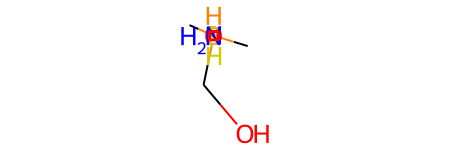

In [74]:
example = mols[0]
example

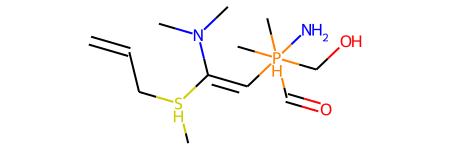

In [76]:
m = Chem.MolFromSmiles(Chem.MolToSmiles(example))
m

In [78]:
with Chem.SDWriter('generated_example.sdf') as w:
  w.write(m)